# BASIC CODE

<ipython-input-12-b718b51797e2>:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sp = pd.read_csv("Eurousd.csv", parse_dates=['Date'], index_col='Date')  # Assuming 'Date' column exists


ADF Test - Original Close
ADF Statistic: -0.0097
p-value: 0.9577
Critical Values: {'1%': np.float64(-3.430419894609131), '5%': np.float64(-2.8615708922987753), '10%': np.float64(-2.566786442893727)}
--------------------------------------------------
ADF Test - Differenced Close
ADF Statistic: -37.4722
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304198998389497), '5%': np.float64(-2.861570894610244), '10%': np.float64(-2.566786444124046)}
--------------------------------------------------
ADF Test - HP Filter - Cyclical Component
ADF Statistic: -30.4089
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304198975975027), '5%': np.float64(-2.861570893619572), '10%': np.float64(-2.566786443596744)}
--------------------------------------------------
ADF Test - Deseasonalized (Intraday Mean Removed)
ADF Statistic: -31.3547
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304198998389497), '5%': np.float64(-2.861570894610244), '10%': np.float64(-2.566786444124046)}
-----

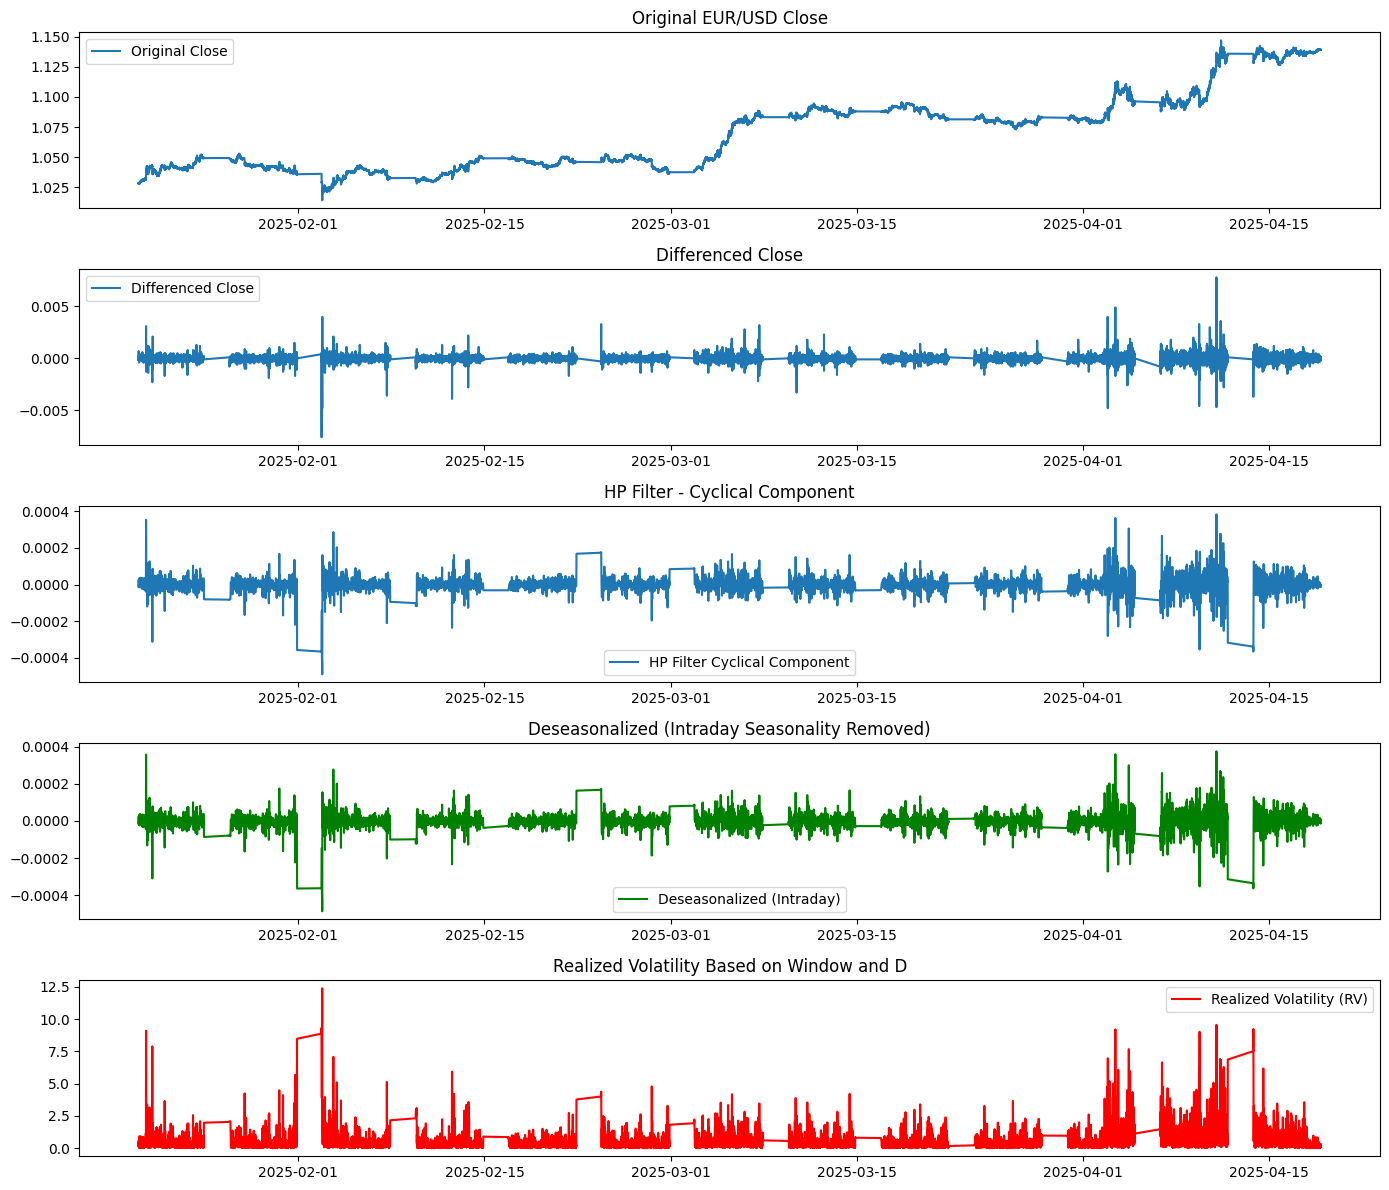

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter

# STEP 0: Load data and ensure 'Close' has a datetime index
sp = pd.read_csv("Eurousd.csv", parse_dates=['Date'], index_col='Date')  # Assuming 'Date' column exists
close = sp['Close'].dropna()

# STEP 1: Differencing to remove trend
diff_close = close.diff().dropna()

# STEP 2: Apply HP filter to extract trend and cyclical components
trend, cyclical = hpfilter(diff_close, lamb=1600)

# STEP 3: Deseasonalize using intraday seasonal mean removal
def deseasonalize_intraday_returns(df, return_col='returns'):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['time'] = df.index.time
    seasonal_pattern = df.groupby('time')[return_col].mean()
    df['seasonal_mean'] = df['time'].map(seasonal_pattern)
    df['deseasonalized'] = df[return_col] - df['seasonal_mean']
    return df['deseasonalized']

# Prepare input DataFrame for deseasonalization (fixing the index issue)
returns_df = pd.DataFrame({'returns': cyclical}, index=diff_close.index)
deseasonalized = deseasonalize_intraday_returns(returns_df, return_col='returns')

# Optional: Scaling the deseasonalized data
deseasonalized_scaled = (deseasonalized - deseasonalized.mean()) / deseasonalized.std()

# STEP 4: Calculate Realized Volatility (RV) using window and D (sampling interval)
D = 5  # Interval size (e.g., 5-minute returns)
window = 5  # Rolling window size for volatility calculation

# Calculate the squared returns (returns^2)
squared_returns = deseasonalized_scaled ** 2

# Calculate Realized Volatility (RV) using a rolling window and D
sp['squared_return'] = squared_returns
sp['realized_vol_D'] = sp['squared_return'].rolling(window=window).sum() / D
sp['realized_vol_D'] = np.sqrt(sp['realized_vol_D'])

# STEP 5: ADF Test function
def run_adf(series, label):
    result = adfuller(series.dropna())
    print(f"ADF Test - {label}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    print("-" * 50)

# Run ADF tests
run_adf(close, "Original Close")
run_adf(diff_close, "Differenced Close")
run_adf(cyclical, "HP Filter - Cyclical Component")
run_adf(deseasonalized, "Deseasonalized (Intraday Mean Removed)")
run_adf(deseasonalized_scaled, "Scaled Deseasonalized")
run_adf(sp['realized_vol_D'], "Realized Volatility (RV)")

# STEP 6: Plot all components
plt.figure(figsize=(14, 12))

# Plot 1: Original EUR/USD Close
plt.subplot(5, 1, 1)
plt.plot(close, label='Original Close')
plt.title("Original EUR/USD Close")
plt.legend()

# Plot 2: Differenced Close
plt.subplot(5, 1, 2)
plt.plot(diff_close, label='Differenced Close')
plt.title("Differenced Close")
plt.legend()

# Plot 3: HP Filter Cyclical Component
plt.subplot(5, 1, 3)
plt.plot(cyclical, label='HP Filter Cyclical Component')
plt.title("HP Filter - Cyclical Component")
plt.legend()

# Plot 4: Deseasonalized (Intraday Seasonality Removed)
plt.subplot(5, 1, 4)
plt.plot(deseasonalized, label='Deseasonalized (Intraday)', color='green')
plt.title("Deseasonalized (Intraday Seasonality Removed)")
plt.legend()

# Plot 5: Realized Volatility (RV)
plt.subplot(5, 1, 5)
plt.plot(sp['realized_vol_D'], label='Realized Volatility (RV)', color='red')
plt.title("Realized Volatility Based on Window and D")
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Drop NaN values in 'realized_vol_D' to ensure clean splitting
clean_vol = sp['realized_vol_D'].dropna()

# Compute split indices for train (40%), validation (30%), test (30%)
n = len(clean_vol)
train_end = int(n * 0.4)
val_end = int(n * 0.7)

# Chronological split
train = clean_vol.iloc[:train_end]
val = clean_vol.iloc[train_end:val_end]
test = clean_vol.iloc[val_end:]


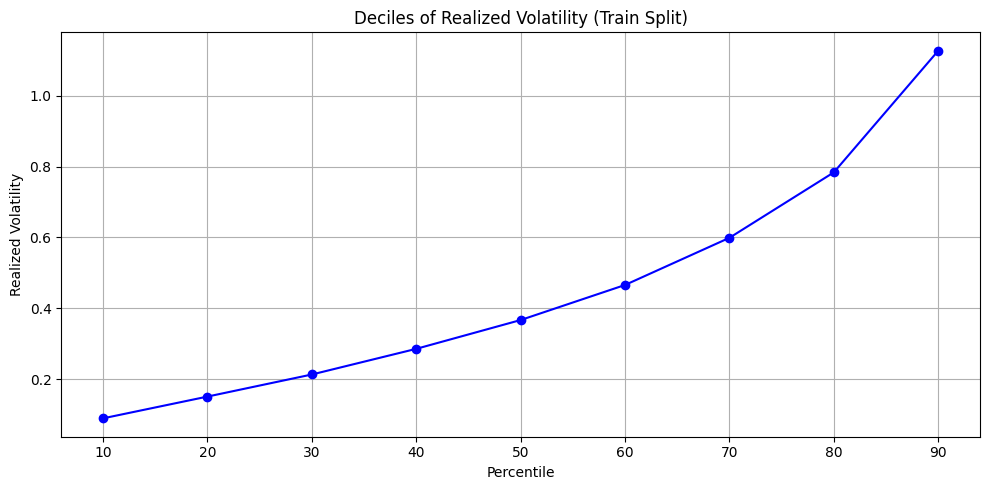

In [14]:
import matplotlib.pyplot as plt

# Calculate deciles
deciles = train.quantile([i / 10 for i in range(1, 10)])

# Plotting the deciles
plt.figure(figsize=(10, 5))
plt.plot(deciles.index * 100, deciles.values, marker='o', linestyle='-', color='blue')
plt.title("Deciles of Realized Volatility (Train Split)")
plt.xlabel("Percentile")
plt.ylabel("Realized Volatility")
plt.xticks(range(10, 100, 10))  # Percentiles from 10 to 90
plt.grid(True)
plt.tight_layout()
plt.show()


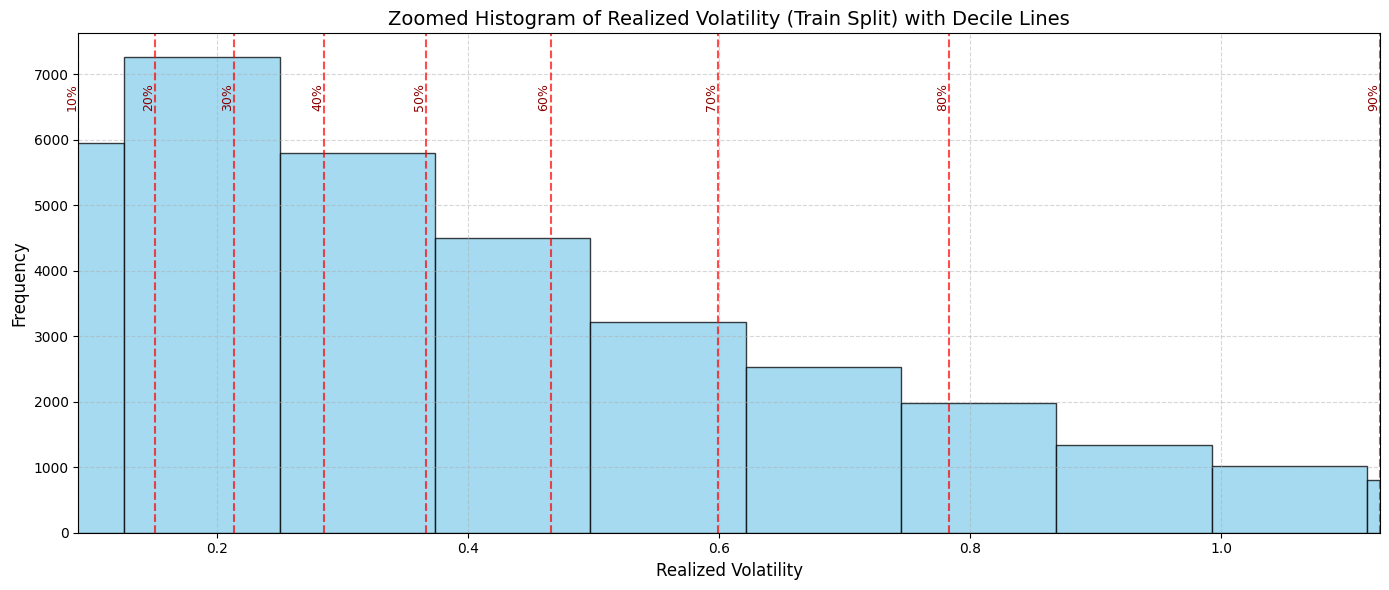

In [5]:
plt.figure(figsize=(14, 6))

# Plot histogram
plt.hist(train, bins=100, color='skyblue', edgecolor='black', alpha=0.75)

# Add decile lines and annotate them
for i, (pct, value) in enumerate(deciles.items(), start=1):
    plt.axvline(value, color='red', linestyle='--', alpha=0.7)
    plt.text(value, plt.ylim()[1]*0.9, f'{int(pct*100)}%', rotation=90,
             verticalalignment='top', horizontalalignment='right', fontsize=9, color='darkred')

# Zoom in on x-axis to the middle 80% range
x_min = train.quantile(0.1)
x_max = train.quantile(0.9)
plt.xlim(x_min, x_max)

# Titles and labels
plt.title("Zoomed Histogram of Realized Volatility (Train Split) with Decile Lines", fontsize=14)
plt.xlabel("Realized Volatility", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [6]:
# Step 1: Get the 10% quantile value from the train data
q10 = train.quantile(0.10)

# Step 2: Subset of train data that lies within the lowest 10%
lowest_10_percent = train[train <= q10]

# Step 3: Compute 10 quantiles within this subset
sub_quantiles = lowest_10_percent.quantile(np.linspace(0.0, 1.0, 11))

# Display results
print("10 Quantile Divisions Within the First 10% of Realized Volatility:")
for i in range(10):
    print(f"Q{i}–Q{i+1}: {sub_quantiles.iloc[i]:.6f} to {sub_quantiles.iloc[i+1]:.6f}")


10 Quantile Divisions Within the First 10% of Realized Volatility:
Q0–Q1: 0.002541 to 0.026811
Q1–Q2: 0.026811 to 0.037289
Q2–Q3: 0.037289 to 0.044658
Q3–Q4: 0.044658 to 0.051835
Q4–Q5: 0.051835 to 0.059114
Q5–Q6: 0.059114 to 0.065543
Q6–Q7: 0.065543 to 0.071831
Q7–Q8: 0.071831 to 0.077853
Q8–Q9: 0.077853 to 0.083620
Q9–Q10: 0.083620 to 0.089725


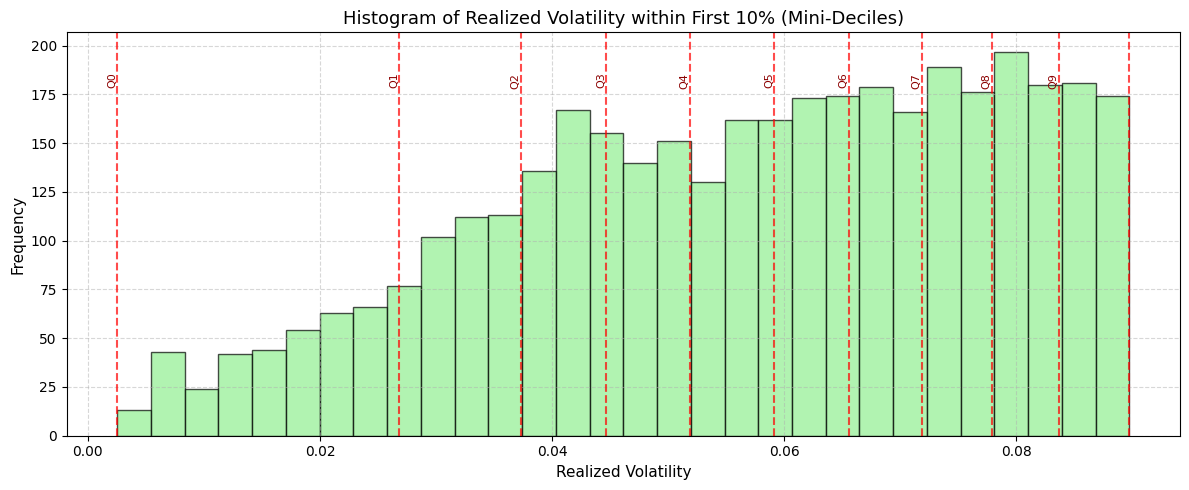

In [7]:
plt.figure(figsize=(12, 5))
plt.hist(lowest_10_percent, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)

# Draw vertical lines for each of the mini-decile cutoffs
for i, val in enumerate(sub_quantiles):
    plt.axvline(val, color='red', linestyle='--', alpha=0.7)
    if i < 10:
        plt.text(val, plt.ylim()[1]*0.9, f'Q{i}', rotation=90,
                 verticalalignment='top', horizontalalignment='right', fontsize=8, color='darkred')

plt.title("Histogram of Realized Volatility within First 10% (Mini-Deciles)", fontsize=13)
plt.xlabel("Realized Volatility", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# TRADING STRAT

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# === Step 1: Prepare your train/val/test splits ===

# Assume 'sp' is your DataFrame and has a 'realized_vol_D' column
clean_vol = sp['realized_vol_D'].dropna()

n = len(clean_vol)
train_end = int(n * 0.4)
val_end = int(n * 0.7)

train_vol = clean_vol.iloc[:train_end]
val_vol = clean_vol.iloc[train_end:val_end]
test_vol = clean_vol.iloc[val_end:]

# === Step 2: Prepare base DataFrame ===

def prepare_data(df):
    df = df.copy()
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['squared_return'] = df['log_return'] ** 2
    return df.dropna(subset=['log_return', 'squared_return'])

train = prepare_data(sp.loc[train_vol.index])
val = prepare_data(sp.loc[val_vol.index])
test = prepare_data(sp.loc[test_vol.index])

# === Step 3: Trading Strategy ===

def run_strategy(
    df, window=14, D=3, roll_mean_window=60,
    vol_entry_thresh=0.014656, vol_exit_multiplier=0.785,
    transaction_cost=0.005, capital_per_trade=1
):
    df = df.copy()
    df['position'] = 0
    df['entry_price'] = np.nan
    df['exit_price'] = np.nan
    df['pnl'] = 0.0

    in_straddle = False
    current_pos = 0
    entry_price = 0.0
    units = 0.0

    start_idx = max(30, window, roll_mean_window)

    for i in tqdm(range(start_idx, len(df)), desc="Running strategy"):
        past_returns = df['squared_return'].iloc[i - window:i]
        if past_returns.isna().sum() > 0:
            continue

        vol = np.sqrt(past_returns.sum() / D)

        vol_history = []
        for j in range(i - 30, i):
            if j >= window:
                past_sq = df['squared_return'].iloc[j - window:j]
                if past_sq.isna().sum() == 0:
                    vol_j = np.sqrt(past_sq.sum() / D)
                    vol_history.append(vol_j)

        if len(vol_history) == 0:
            continue

        vol_mean = np.mean(vol_history)
        log_r = df['log_return'].iloc[i]
        roll_mean = df['log_return'].iloc[i - roll_mean_window:i].mean()
        price = df['Close'].iloc[i]

        if not in_straddle:
            if vol <= vol_entry_thresh:
                in_straddle = True
                df.iloc[i, df.columns.get_loc('position')] = 2  # straddle/neutral entry
                entry_price = price * (1 + transaction_cost)  # cost applied
                units = capital_per_trade / entry_price
                df.iloc[i, df.columns.get_loc('entry_price')] = entry_price
        else:
            if current_pos == 0:
                if log_r > roll_mean:
                    current_pos = 1  # long
                elif log_r < roll_mean:
                    current_pos = -1  # short

            if vol >= vol_mean * vol_exit_multiplier:
                df.iloc[i, df.columns.get_loc('position')] = 0
                df.iloc[i, df.columns.get_loc('exit_price')] = price

                if current_pos == 1:
                    pnl = units * (price - entry_price)
                elif current_pos == -1:
                    pnl = units * (entry_price - price)
                else:
                    pnl = 0.0

                df.iloc[i, df.columns.get_loc('pnl')] = pnl

                # Reset state
                in_straddle = False
                current_pos = 0
                entry_price = 0.0
                units = 0.0
            else:
                df.iloc[i, df.columns.get_loc('position')] = current_pos

    return df

# === Step 4: Run Strategy on Train and Test ===

train_result = run_strategy(train)
test_result = run_strategy(test)

# === Step 5: Summary Statistics ===

def summarize(result, label):
    print(f"\n📊 {label} Performance:")
    trades = result['pnl'].ne(0).sum()
    total_pnl = result['pnl'].sum()
    mean_pnl = result.loc[result['pnl'] != 0, 'pnl'].mean()
    print(f"Total Trades Executed: {trades}")
    print(f"Total P&L: {total_pnl:.4f}")
    print(f"Average P&L per Trade: {mean_pnl:.4f}")

summarize(train_result, "Train")
summarize(test_result, "Test")
# To evaluate on validation:
# val_result = run_strategy(val)
# summarize(val_result, "Validation")


Running strategy: 100%|██████████| 28025/28025 [02:02<00:00, 229.46it/s]


📊 Train Performance:
Total Trades Executed: 15380
Total P&L: 1.1610
Average P&L per Trade: 0.0001

📊 Test Performance:
Total Trades Executed: 11470
Total P&L: 2.6638
Average P&L per Trade: 0.0002


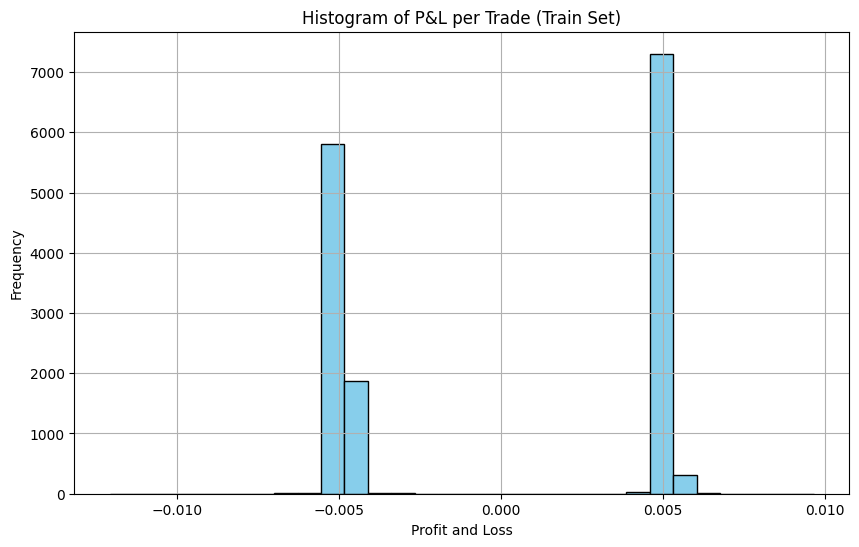

In [44]:
# Plot histogram of returns from trades
trade_returns = train_result['pnl'][train_result['pnl'] != 0]

plt.figure(figsize=(10, 6))
plt.hist(trade_returns, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of P&L per Trade (Train Set)")
plt.xlabel("Profit and Loss")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


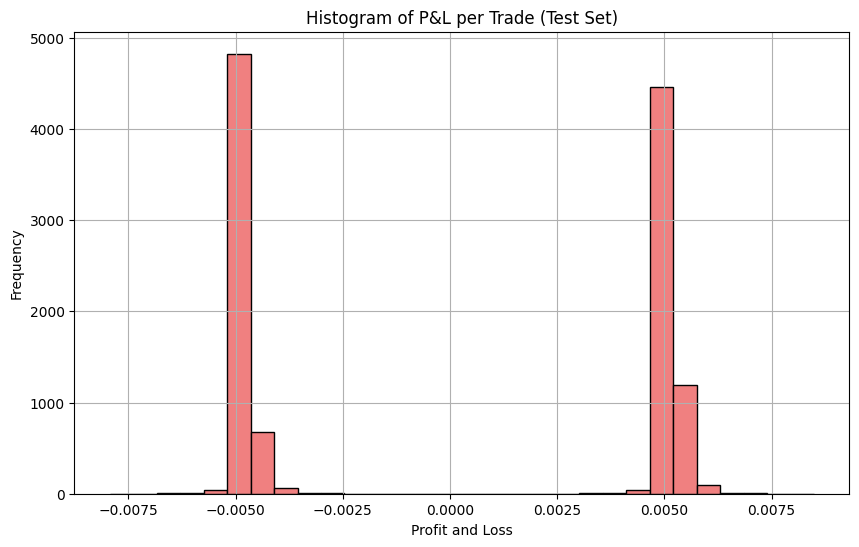

In [45]:
# Filter non-zero trade P&L values from the test results
test_trade_returns = test_result['pnl'][test_result['pnl'] != 0]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(test_trade_returns, bins=30, color='lightcoral', edgecolor='black')
plt.title("Histogram of P&L per Trade (Test Set)")
plt.xlabel("Profit and Loss")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [46]:
# Updated summary function with win/loss stats
def summarize(result, label):
    print(f"{label} Performance:")
    trades = result['pnl'] != 0
    total_trades = trades.sum()
    total_pnl = result.loc[trades, 'pnl'].sum()
    mean_pnl = result.loc[trades, 'pnl'].mean()

    winning_trades = (result['pnl'] > 0).sum()
    losing_trades = (result['pnl'] < 0).sum()
    win_rate = winning_trades / total_trades * 100 if total_trades > 0 else 0

    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Losing Trades: {losing_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total P&L: {total_pnl:.4f}")
    print(f"Mean P&L: {mean_pnl:.4f}\n")
summarize(train_result, "Train")
# Assuming the summarize function is already defined as above
summarize(test_result, "Test")




Train Performance:
Total Trades: 15380
Winning Trades: 7656
Losing Trades: 7724
Win Rate: 49.78%
Total P&L: 1.1610
Mean P&L: 0.0001

Test Performance:
Total Trades: 11470
Winning Trades: 5828
Losing Trades: 5642
Win Rate: 50.81%
Total P&L: 2.6638
Mean P&L: 0.0002



===== Train Performance =====
Sharpe Ratio: 1.8801
Max Drawdown: $58.28 (31.87%)
Final Equity: $216.10
--------------------------------------------------
===== Test Performance =====
Sharpe Ratio: 4.9973
Max Drawdown: $37.70 (34.99%)
Final Equity: $366.38
--------------------------------------------------


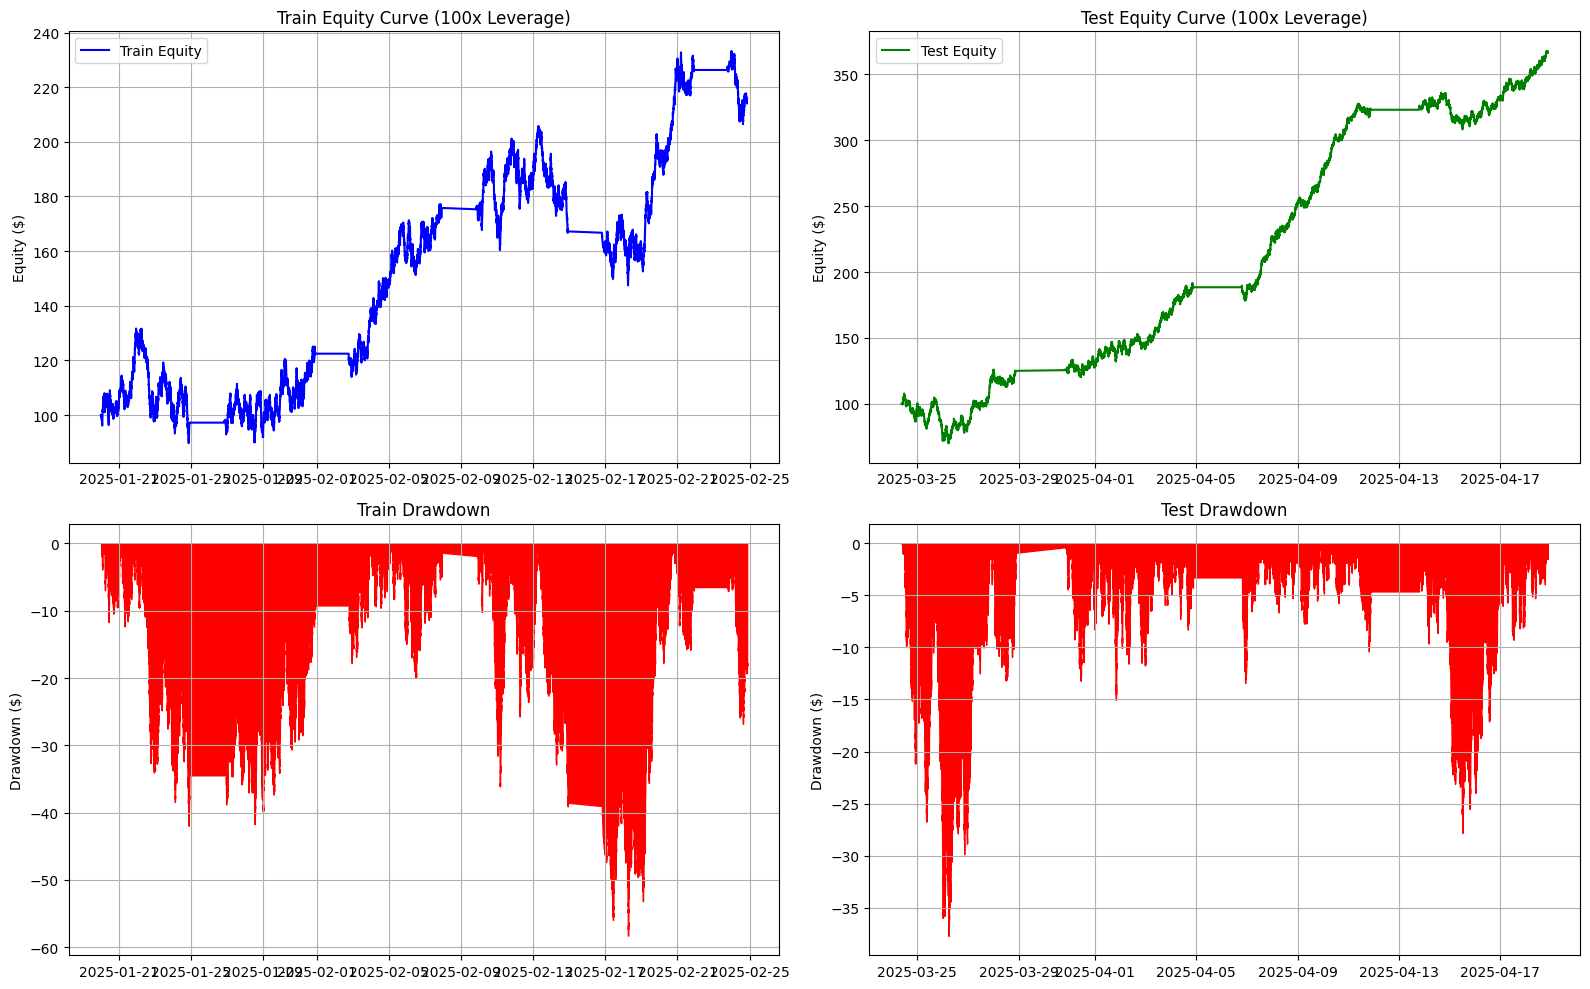

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_strategy(df, label, leverage=100):
    df = df.copy()

    # Apply leverage
    df['pnl_leveraged'] = df['pnl'] * leverage

    # Equity curve
    df['cumulative_pnl'] = df['pnl_leveraged'].cumsum()
    df['equity'] = 100 + df['cumulative_pnl']

    # Sharpe Ratio
    returns = df['pnl_leveraged'][df['pnl_leveraged'] != 0]
    sharpe = returns.mean() / returns.std() * np.sqrt(len(returns))

    # Drawdown
    df['rolling_max'] = df['equity'].cummax()
    df['drawdown'] = df['equity'] - df['rolling_max']
    df['drawdown_pct'] = df['drawdown'] / df['rolling_max']
    max_dd = df['drawdown'].min()
    max_dd_pct = df['drawdown_pct'].min()

    print(f"===== {label} Performance =====")
    print(f"Sharpe Ratio: {sharpe:.4f}")
    print(f"Max Drawdown: ${abs(max_dd):.2f} ({abs(max_dd_pct)*100:.2f}%)")
    print(f"Final Equity: ${df['equity'].iloc[-1]:.2f}")
    print("-" * 50)

    return df

# Evaluate both sets
train_eval = evaluate_strategy(train_result, "Train", leverage=100)
test_eval = evaluate_strategy(test_result, "Test", leverage=100)

# Plot Equity Curves and Drawdowns
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=False)

# Train Equity
axs[0, 0].plot(train_eval.index, train_eval['equity'], label='Train Equity', color='blue')
axs[0, 0].set_title("Train Equity Curve (100x Leverage)")
axs[0, 0].set_ylabel("Equity ($)")
axs[0, 0].grid(True)
axs[0, 0].legend()

# Train Drawdown
axs[1, 0].fill_between(train_eval.index, train_eval['drawdown'], color='red')
axs[1, 0].set_title("Train Drawdown")
axs[1, 0].set_ylabel("Drawdown ($)")
axs[1, 0].grid(True)

# Test Equity
axs[0, 1].plot(test_eval.index, test_eval['equity'], label='Test Equity', color='green')
axs[0, 1].set_title("Test Equity Curve (100x Leverage)")
axs[0, 1].set_ylabel("Equity ($)")
axs[0, 1].grid(True)
axs[0, 1].legend()

# Test Drawdown
axs[1, 1].fill_between(test_eval.index, test_eval['drawdown'], color='red')
axs[1, 1].set_title("Test Drawdown")
axs[1, 1].set_ylabel("Drawdown ($)")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


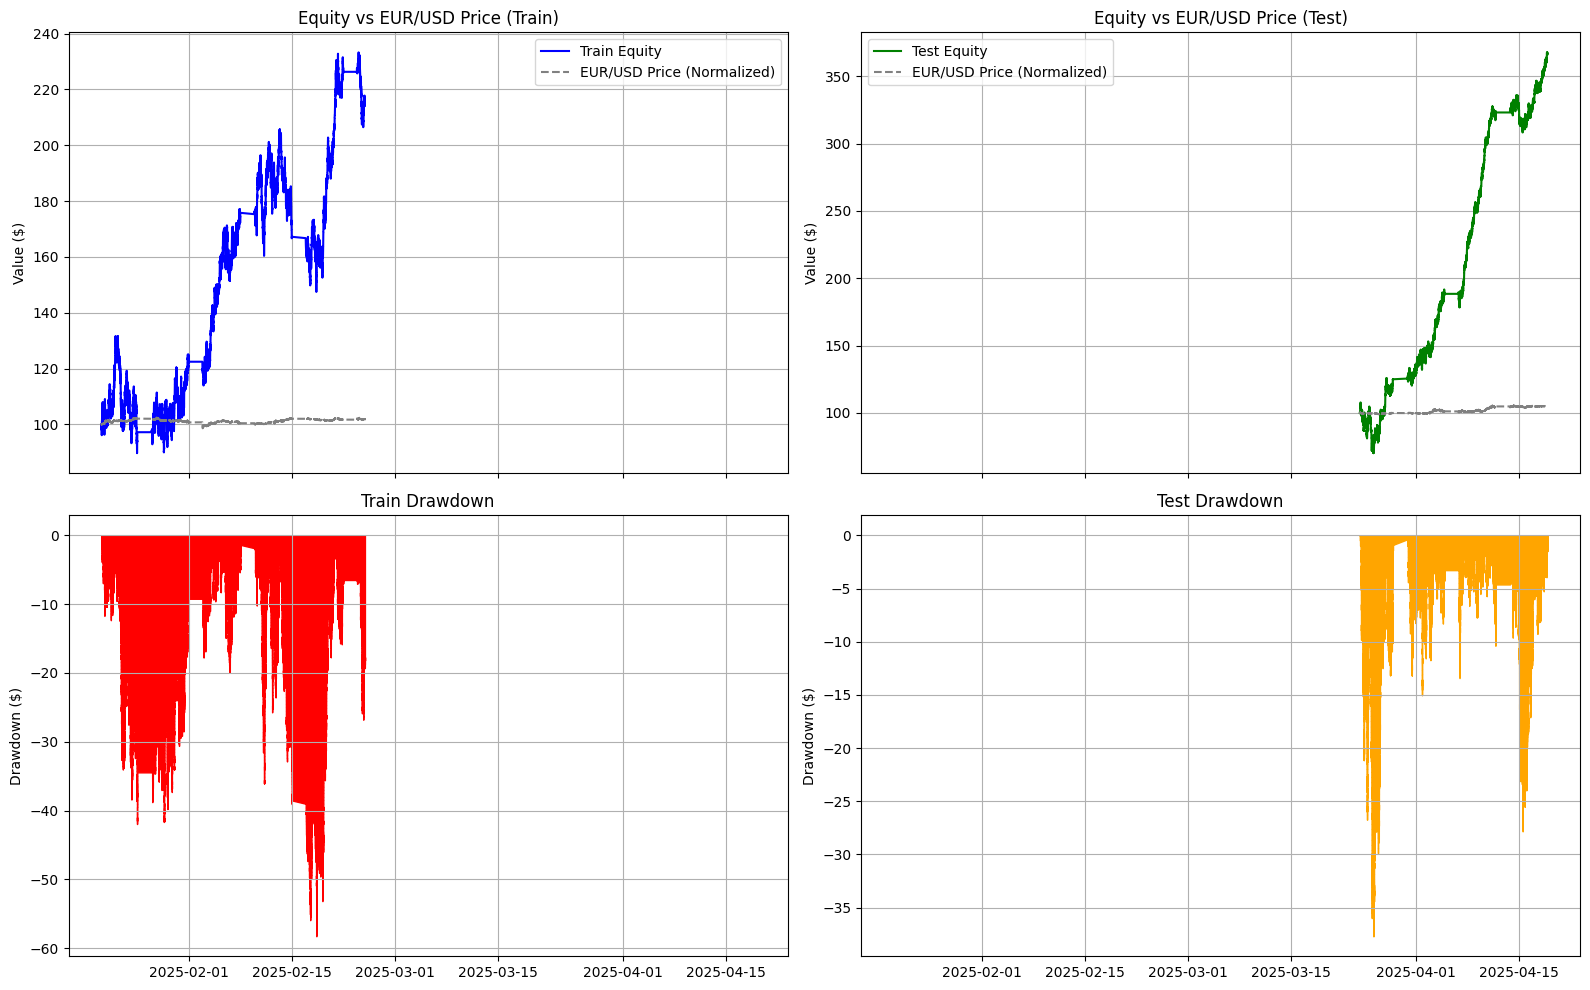

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# Normalize actual close prices to start at $100
normalized_train_price = train_eval['Close'] / train_eval['Close'].iloc[0] * 100
normalized_test_price = test_eval['Close'] / test_eval['Close'].iloc[0] * 100

# === Train Equity vs Price ===
axs[0, 0].plot(train_eval.index, train_eval['equity'], label='Train Equity', color='blue')
axs[0, 0].plot(train_eval.index, normalized_train_price, label='EUR/USD Price (Normalized)', color='gray', linestyle='--')
axs[0, 0].set_title("Equity vs EUR/USD Price (Train)")
axs[0, 0].set_ylabel("Value ($)")
axs[0, 0].grid(True)
axs[0, 0].legend()

# === Train Drawdown ===
axs[1, 0].fill_between(train_eval.index, train_eval['drawdown'], color='red')
axs[1, 0].set_title("Train Drawdown")
axs[1, 0].set_ylabel("Drawdown ($)")
axs[1, 0].grid(True)

# === Test Equity vs Price ===
axs[0, 1].plot(test_eval.index, test_eval['equity'], label='Test Equity', color='green')
axs[0, 1].plot(test_eval.index, normalized_test_price, label='EUR/USD Price (Normalized)', color='gray', linestyle='--')
axs[0, 1].set_title("Equity vs EUR/USD Price (Test)")
axs[0, 1].set_ylabel("Value ($)")
axs[0, 1].grid(True)
axs[0, 1].legend()

# === Test Drawdown ===
axs[1, 1].fill_between(test_eval.index, test_eval['drawdown'], color='orange')
axs[1, 1].set_title("Test Drawdown")
axs[1, 1].set_ylabel("Drawdown ($)")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [40]:
# Calculate daily returns
equity_returns = train_eval['equity'].pct_change().dropna()
price_returns = train_eval['Close'].pct_change().dropna()

# Align the two series
aligned = pd.concat([equity_returns, price_returns], axis=1).dropna()
aligned.columns = ['Equity_Returns', 'Price_Returns']

# Correlation of returns
correlation_returns = aligned['Equity_Returns'].corr(aligned['Price_Returns'])
print(f"Correlation between Daily Returns: {correlation_returns:.4f}")


Correlation between Daily Returns: -0.3469


In [55]:
# Calculate daily returns
equity_returns = test_eval['equity'].pct_change().dropna()
price_returns = test_eval['Close'].pct_change().dropna()

# Align the two series
aligned = pd.concat([equity_returns, price_returns], axis=1).dropna()
aligned.columns = ['Equity_Returns', 'Price_Returns']

# Correlation of returns
correlation_returns = aligned['Equity_Returns'].corr(aligned['Price_Returns'])
print(f"Correlation between Daily Returns: {correlation_returns:.4f}")


Correlation between Daily Returns: -0.2985


# MONTE CARLO SIMULATION

Running Monte Carlo Simulations: 100%|██████████| 50/50 [2:37:45<00:00, 189.32s/it]

Top 5 Parameter Combinations:
     window  D  roll_mean_window  vol_entry_thresh  vol_exit_multiplier  \
6       14  3                60          0.014656             0.785018   
8       10  7               150          0.024622             0.757413   
29       5  7               150          0.048482             0.706978   
19       5  7                30          0.023857             0.744982   
9       14  5               120          0.056545             0.827497   

    transaction_cost  total_pnl  mean_pnl  num_trades  max_drawdown  
6                0.0     1.0073  0.000129        7809       -0.0030  
8                0.0     1.0001  0.000128        7796       -0.0134  
29               0.0     0.9906  0.000127        7802       -0.0027  
19               0.0     0.9392  0.000124        7555       -0.0027  
9                0.0     0.9372  0.000128        7310       -0.0036  


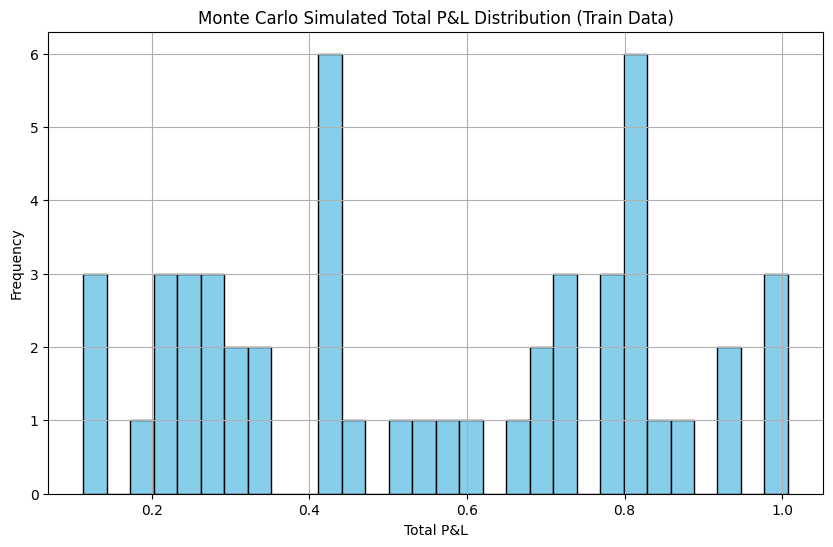

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# === Step 1: Prepare your train/val/test splits ===

# Assuming 'sp' is your main DataFrame and 'realized_vol_D' exists
clean_vol = sp['realized_vol_D'].dropna()

n = len(clean_vol)
train_end = int(n * 0.4)
val_end = int(n * 0.7)

# Chronological split
train_vol = clean_vol.iloc[:train_end]
val_vol = clean_vol.iloc[train_end:val_end]
test_vol = clean_vol.iloc[val_end:]

# === Step 2: Prepare train DataFrame with needed columns ===

# Let's assume you want to run on the full DataFrame rows corresponding to train_vol index,
# so slice sp to only train rows
train = sp.loc[train_vol.index].copy()

# Calculate log returns and squared returns for train
train['log_return'] = np.log(train['Close'] / train['Close'].shift(1))
train['squared_return'] = train['log_return'] ** 2

# Drop any NaNs created by shift or log
train.dropna(subset=['log_return', 'squared_return'], inplace=True)


# === Step 3: Your strategy function ===

def run_strategy(df, window=5, D=5, roll_mean_window=60, vol_entry_thresh=0.04, vol_exit_multiplier=1.0, transaction_cost=0.00):
    df = df.copy()
    df['position'] = 0
    df['entry_price'] = np.nan
    df['exit_price'] = np.nan
    df['pnl'] = 0.0

    in_straddle = False
    current_pos = 0
    entry_price = 0.0

    for i in range(max(30, window, roll_mean_window), len(df)):
        past_squared_returns = df['squared_return'].iloc[i - window:i]
        if len(past_squared_returns.dropna()) < window:
            continue
        vol = np.sqrt(past_squared_returns.sum() / D)

        vol_history = []
        for j in range(i - 30, i):
            if j >= window:
                past_sq = df['squared_return'].iloc[j - window:j]
                if len(past_sq.dropna()) == window:
                    vol_j = np.sqrt(past_sq.sum() / D)
                    vol_history.append(vol_j)
        if len(vol_history) == 0:
            continue
        vol_mean = np.mean(vol_history)

        log_r = df['log_return'].iloc[i]
        roll_mean = df['log_return'].iloc[i - roll_mean_window:i].mean()
        price = df['Close'].iloc[i]

        if not in_straddle:
            if vol <= vol_entry_thresh:
                in_straddle = True
                df.iloc[i, df.columns.get_loc('position')] = 2
                entry_price = price
                df.iloc[i, df.columns.get_loc('entry_price')] = price
        else:
            if current_pos == 0:
                if log_r > roll_mean:
                    current_pos = 1
                elif log_r < roll_mean:
                    current_pos = -1
            elif vol >= vol_mean * vol_exit_multiplier:
                df.iloc[i, df.columns.get_loc('position')] = 0
                df.iloc[i, df.columns.get_loc('exit_price')] = price
                if current_pos == 1:
                    pnl = price - entry_price - (transaction_cost * entry_price)
                elif current_pos == -1:
                    pnl = entry_price - price - (transaction_cost * entry_price)
                else:
                    pnl = 0.0
                df.iloc[i, df.columns.get_loc('pnl')] = pnl
                in_straddle = False
                current_pos = 0
                entry_price = 0.0
            else:
                df.iloc[i, df.columns.get_loc('position')] = current_pos

    return df


# === Step 4: Monte Carlo simulation ===

def monte_carlo_simulation(data, n_iter=50):
    results = []

    for _ in tqdm(range(n_iter), desc="Running Monte Carlo Simulations"):
        params = {
            'window': np.random.choice([3, 5, 7, 10, 14, 20]),
            'D': np.random.choice([3, 5, 7, 10, 14]),
            'roll_mean_window': np.random.choice([30, 60, 90, 120, 150]),
            'vol_entry_thresh': np.random.uniform(0.01, 0.08),
            'vol_exit_multiplier': np.random.uniform(0.7, 1.5),
            'transaction_cost': 0.0  # fixed 0 for now
        }

        result_df = run_strategy(
            data,
            window=params['window'],
            D=params['D'],
            roll_mean_window=params['roll_mean_window'],
            vol_entry_thresh=params['vol_entry_thresh'],
            vol_exit_multiplier=params['vol_exit_multiplier'],
            transaction_cost=params['transaction_cost']
        )

        trades = result_df['pnl'] != 0
        total_pnl = result_df.loc[trades, 'pnl'].sum()
        mean_pnl = result_df.loc[trades, 'pnl'].mean() if trades.sum() > 0 else 0
        # equity series to calculate drawdown if needed
        result_df['equity'] = result_df['pnl'].cumsum()
        max_drawdown = (result_df['equity'] - result_df['equity'].cummax()).min()

        results.append({
            **params,
            'total_pnl': total_pnl,
            'mean_pnl': mean_pnl,
            'num_trades': trades.sum(),
            'max_drawdown': max_drawdown
        })

    return pd.DataFrame(results)


# === Step 5: Run the simulation on train data ===

monte_carlo_results = monte_carlo_simulation(train)

# Print top 5 parameter sets by total P&L
top5 = monte_carlo_results.sort_values(by='total_pnl', ascending=False).head(5)
print("Top 5 Parameter Combinations:\n", top5)

# Plot total P&L distribution
plt.figure(figsize=(10, 6))
plt.hist(monte_carlo_results['total_pnl'], bins=30, color='skyblue', edgecolor='black')
plt.title("Monte Carlo Simulated Total P&L Distribution (Train Data)")
plt.xlabel("Total P&L")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# OTHER ANALYSIS

Descriptive Statistics for 5-Minute Log Returns (First Half):
count    2.351700e+04
mean     5.205851e-07
std      4.045766e-04
min     -9.895735e-03
25%     -1.914242e-04
50%      0.000000e+00
75%      1.918097e-04
max      7.919686e-03
Name: Close, dtype: float64

Mean: 0.000001
IQR (Interquartile Range): 0.000383


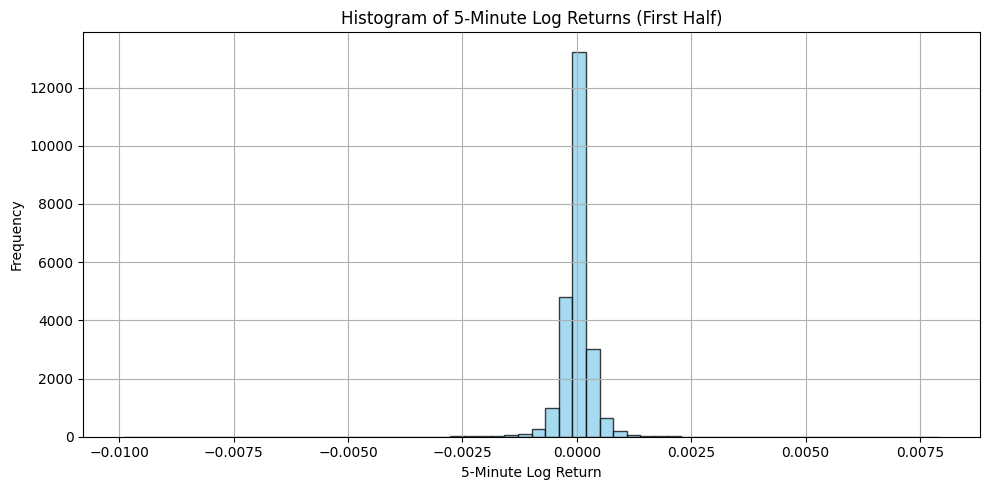

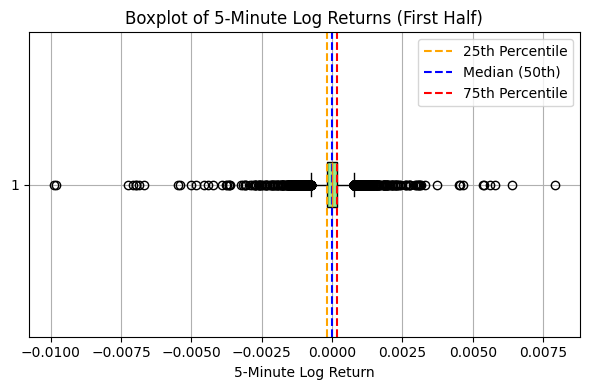

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Drop missing prices and take first half
price_full = sp['Close'].dropna()
price_half = price_full.iloc[:len(price_full) // 2]

# Step 1: Compute 5-minute log returns on the first half
log_returns_5min_half = np.log(price_half / price_half.shift(5)).dropna()

# Step 2: Descriptive statistics
desc_stats = log_returns_5min_half.describe()
mean_return = log_returns_5min_half.mean()
iqr = desc_stats['75%'] - desc_stats['25%']

print("Descriptive Statistics for 5-Minute Log Returns (First Half):")
print(desc_stats)
print(f"\nMean: {mean_return:.6f}")
print(f"IQR (Interquartile Range): {iqr:.6f}")

# Step 3: Histogram
plt.figure(figsize=(10, 5))
plt.hist(log_returns_5min_half, bins=60, color='skyblue', edgecolor='black', alpha=0.75)
plt.title("Histogram of 5-Minute Log Returns (First Half)")
plt.xlabel("5-Minute Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Boxplot with labels
plt.figure(figsize=(6, 4))
plt.boxplot(log_returns_5min_half, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))

plt.title("Boxplot of 5-Minute Log Returns (First Half)")
plt.xlabel("5-Minute Log Return")
plt.grid(True)

# Annotate key percentiles
plt.axvline(desc_stats['25%'], color='orange', linestyle='--', label="25th Percentile")
plt.axvline(desc_stats['50%'], color='blue', linestyle='--', label="Median (50th)")
plt.axvline(desc_stats['75%'], color='red', linestyle='--', label="75th Percentile")
plt.legend()

plt.tight_layout()
plt.show()


Delta changes in Realized Volatility (first half):
[-0.03418829  0.05992505  0.10015959 ...  0.02144419  0.03501538
  0.03739542]


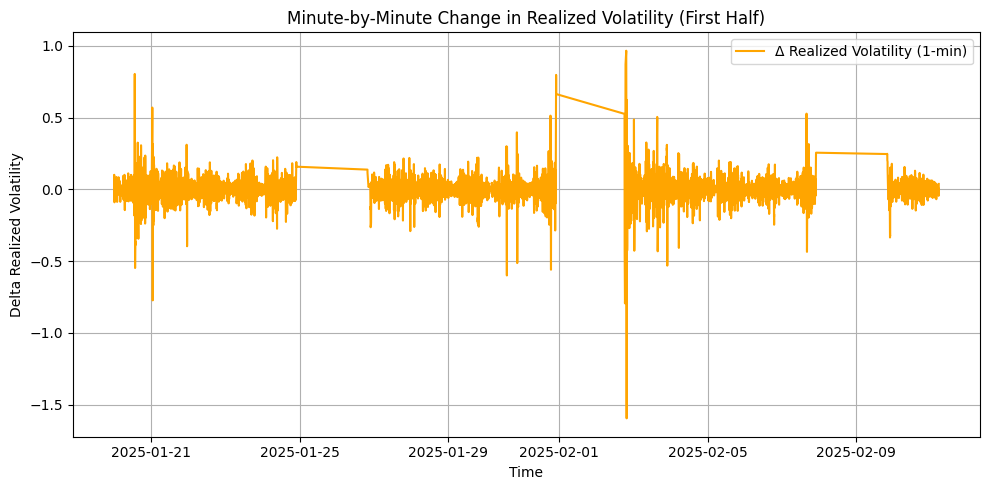

In [ ]:
# Compute delta change (1st difference) in realized volatility
realized_vol = sp['realized_vol_D'].dropna()
delta_rv = realized_vol.diff().dropna()

# Take the first half of delta changes
delta_rv_first_half = delta_rv.iloc[:len(delta_rv) // 2]

# Optional: Convert to NumPy array if you need it as an array
delta_rv_array = delta_rv_first_half.to_numpy()

# Print the array (optional)
print("Delta changes in Realized Volatility (first half):")
print(delta_rv_array)

# Plot the delta changes
plt.figure(figsize=(10, 5))
plt.plot(delta_rv_first_half.index, delta_rv_first_half, color='orange', label='Δ Realized Volatility (1-min)')
plt.title("Minute-by-Minute Change in Realized Volatility (First Half)")
plt.xlabel("Time")
plt.ylabel("Delta Realized Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Delta changes in Realized Volatility (first half):
[-0.03418829  0.05992505  0.10015959 ...  0.02144419  0.03501538
  0.03739542]

Quartile Labels for Delta Changes in Realized Volatility:
Date
2025-01-20 00:07:00              Q2
2025-01-20 00:08:00    Q4 (Highest)
2025-01-20 00:09:00    Q4 (Highest)
2025-01-20 00:10:00    Q4 (Highest)
2025-01-20 00:11:00    Q4 (Highest)
                           ...     
2025-02-11 05:17:00              Q2
2025-02-11 05:18:00              Q2
2025-02-11 05:19:00              Q3
2025-02-11 05:20:00              Q3
2025-02-11 05:21:00              Q3
Name: delta_vol_quartile, Length: 23519, dtype: category
Categories (4, object): ['Q1 (Lowest)' < 'Q2' < 'Q3' < 'Q4 (Highest)']


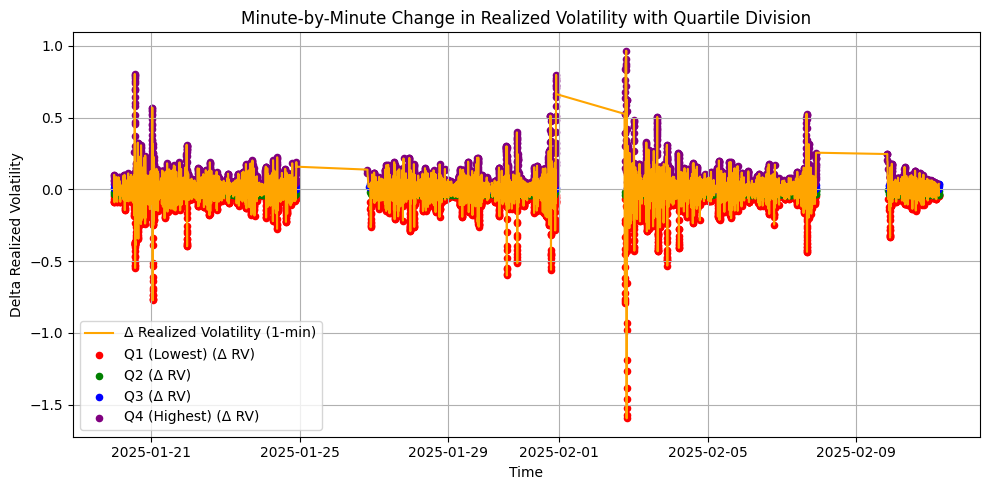

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'sp['realized_vol_D']' already exists

# Step 1: Compute delta change (1st difference) in realized volatility
realized_vol = sp['realized_vol_D'].dropna()
delta_rv = realized_vol.diff().dropna()

# Step 2: Take the first half of delta changes
delta_rv_first_half = delta_rv.iloc[:len(delta_rv) // 2]

# Step 3: Create quartiles for delta changes
quartiles = pd.qcut(delta_rv_first_half, q=4, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])

# Step 4: Assign quartile labels back to DataFrame (same index as delta_rv_first_half)
sp.loc[delta_rv_first_half.index, 'delta_vol_quartile'] = quartiles

# Step 5: Convert to NumPy array if needed
delta_rv_array = delta_rv_first_half.to_numpy()

# Print the array and quartile labels (optional)
print("Delta changes in Realized Volatility (first half):")
print(delta_rv_array)
print("\nQuartile Labels for Delta Changes in Realized Volatility:")
print(sp.loc[delta_rv_first_half.index, 'delta_vol_quartile'])

# Step 6: Plot the delta changes, highlighting the quartile division
plt.figure(figsize=(10, 5))
plt.plot(delta_rv_first_half.index, delta_rv_first_half, color='orange', label='Δ Realized Volatility (1-min)')

# Highlight the quartiles
colors = ['red', 'green', 'blue', 'purple']
for i, quartile in enumerate(['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']):
    quartile_data = delta_rv_first_half[sp.loc[delta_rv_first_half.index, 'delta_vol_quartile'] == quartile]
    plt.scatter(quartile_data.index, quartile_data, color=colors[i], label=f'{quartile} (Δ RV)', s=20)

# Customize plot
plt.title("Minute-by-Minute Change in Realized Volatility with Quartile Division")
plt.xlabel("Time")
plt.ylabel("Delta Realized Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


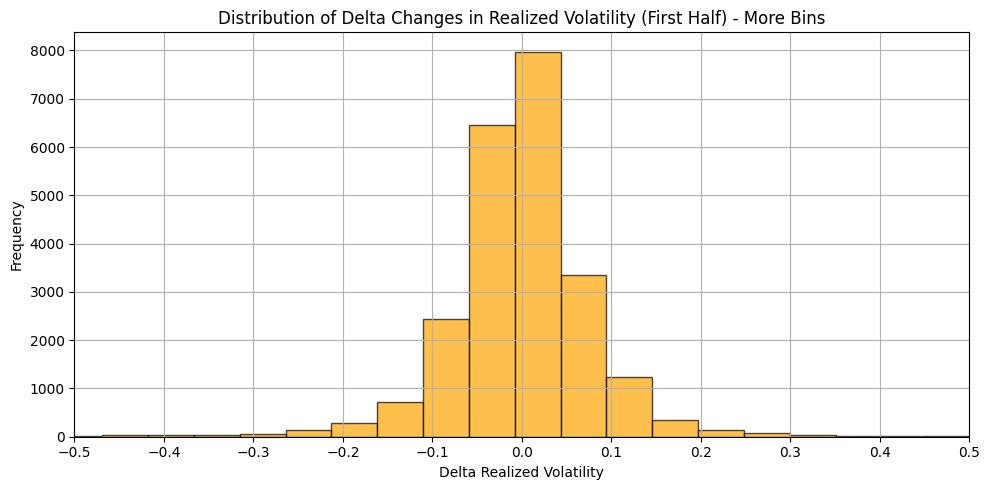

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'sp['realized_vol_D']' already exists

# Step 1: Compute delta change (1st difference) in realized volatility
realized_vol = sp['realized_vol_D'].dropna()
delta_rv = realized_vol.diff().dropna()

# Step 2: Take the first half of delta changes
delta_rv_first_half = delta_rv.iloc[:len(delta_rv) // 2]

# Step 3: Plot the histogram with more smaller bins
plt.figure(figsize=(10, 5))
plt.hist(delta_rv_first_half, bins=50, color='orange', edgecolor='black', alpha=0.7)

# Step 4: Adjust x-axis limits to match the data range
plt.xlim(-0.5, 0.5)  # Set x-axis limits based on the data spread

# Step 5: Add more x-tick labels for clarity
plt.xticks(np.linspace(-0.5, 0.5, 11))  # 11 ticks, spaced evenly from -0.5 to 0.5

# Add labels and title
plt.title("Distribution of Delta Changes in Realized Volatility (First Half) - More Bins")
plt.xlabel("Delta Realized Volatility")
plt.ylabel("Frequency")

# Customize the grid and layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


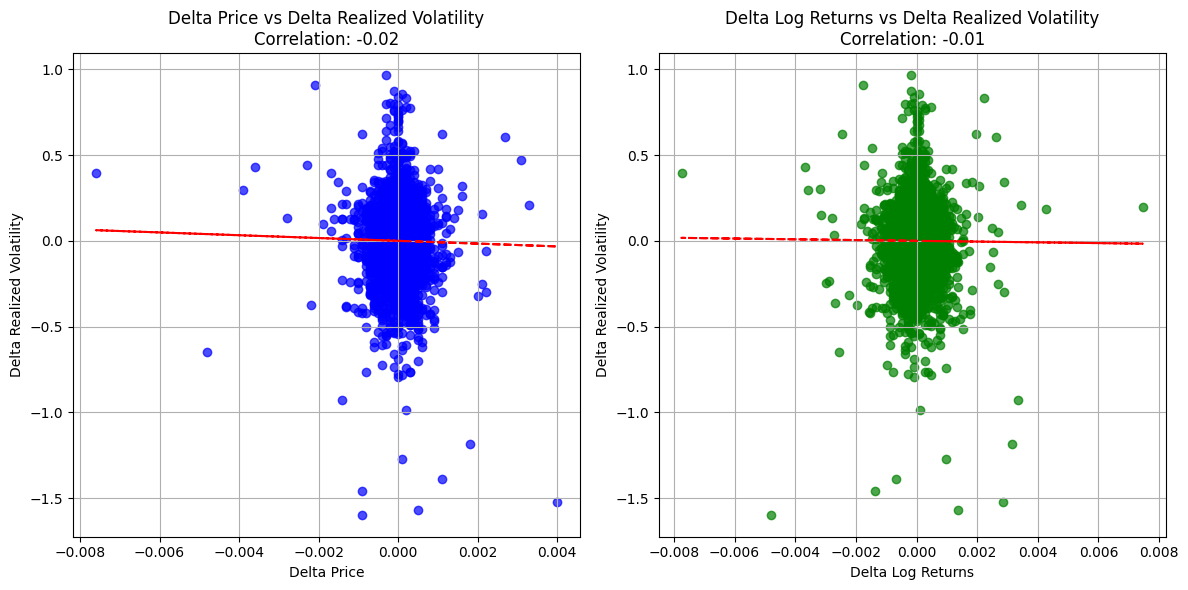

Correlation between delta in price and delta in realized volatility: -0.02
Correlation between delta in log returns and delta in realized volatility: -0.01


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'sp['realized_vol_D']' and 'sp['price']' already exist

# Step 1: Compute delta change in realized volatility (1st difference)
realized_vol = sp['realized_vol_D'].dropna()
delta_rv = realized_vol.diff().dropna()

# Step 2: Compute delta change in price (1st difference)
price = sp['Close'].dropna()  # Assuming 'price' is your price column
delta_price = price.diff().dropna()

# Step 3: Compute log returns (assuming 'price' is your price column)
log_returns = np.log(price / price.shift(1)).dropna()

# Step 4: Compute delta change in log returns (1st difference)
delta_log_returns = log_returns.diff().dropna()

# Step 5: Align the delta changes by their index
# Align both delta_rv and delta_price, as well as delta_rv and delta_log_returns
common_index_price = delta_rv.index.intersection(delta_price.index)
common_index_log_returns = delta_rv.index.intersection(delta_log_returns.index)

delta_rv_price = delta_rv.loc[common_index_price]
delta_price = delta_price.loc[common_index_price]

delta_rv_log_returns = delta_rv.loc[common_index_log_returns]
delta_log_returns = delta_log_returns.loc[common_index_log_returns]

# Step 6: Calculate the correlation between delta changes in price and delta realized volatility
correlation_price = delta_rv_price.corr(delta_price)

# Step 7: Calculate the correlation between delta changes in log returns and delta realized volatility
correlation_log_returns = delta_rv_log_returns.corr(delta_log_returns)

# Step 8: Plot the scatter plot for delta_price vs delta_rv
plt.figure(figsize=(12, 6))

# Subplot 1: Delta Price vs Delta Realized Volatility
plt.subplot(1, 2, 1)
plt.scatter(delta_price, delta_rv_price, color='blue', alpha=0.7)
plt.title(f"Delta Price vs Delta Realized Volatility\nCorrelation: {correlation_price:.2f}")
plt.xlabel("Delta Price")
plt.ylabel("Delta Realized Volatility")
plt.grid(True)

# Optional: Add a line of best fit
z_price = np.polyfit(delta_price, delta_rv_price, 1)
p_price = np.poly1d(z_price)
plt.plot(delta_price, p_price(delta_price), color='red', linestyle='--', label="Best Fit Line")

# Subplot 2: Delta Log Returns vs Delta Realized Volatility
plt.subplot(1, 2, 2)
plt.scatter(delta_log_returns, delta_rv_log_returns, color='green', alpha=0.7)
plt.title(f"Delta Log Returns vs Delta Realized Volatility\nCorrelation: {correlation_log_returns:.2f}")
plt.xlabel("Delta Log Returns")
plt.ylabel("Delta Realized Volatility")
plt.grid(True)

# Optional: Add a line of best fit
z_log = np.polyfit(delta_log_returns, delta_rv_log_returns, 1)
p_log = np.poly1d(z_log)
plt.plot(delta_log_returns, p_log(delta_log_returns), color='red', linestyle='--', label="Best Fit Line")

# Adjust layout
plt.tight_layout()
plt.show()

# Print correlation values
print(f"Correlation between delta in price and delta in realized volatility: {correlation_price:.2f}")
print(f"Correlation between delta in log returns and delta in realized volatility: {correlation_log_returns:.2f}")


In [ ]:
# Split into 70% training and 30% testing (untouched)
train_size = int(len(sp) * 0.7)
train_data = sp.iloc[:train_size]
test_data = sp.iloc[train_size:]

# Separate the last 30% of the data as the final test set
final_test_data = test_data.copy()  # This will remain untouched for now


In [ ]:
# Split the 70% training data into 50% train and 20% test
train_size_50 = int(len(train_data) * 0.5)
val_data = train_data.iloc[train_size_50:]
train_data = train_data.iloc[:train_size_50]


In [ ]:
print(f"Train Data Size: {len(train_data)}")
print(f"Validation Data Size: {len(val_data)}")
print(f"Final Test Data Size: {len(final_test_data)}")

# Ensure that the sum equals the original dataset length
print(f"Total Data Size: {len(train_data) + len(val_data) + len(final_test_data)}")


Train Data Size: 32768
Validation Data Size: 32769
Final Test Data Size: 28088
Total Data Size: 93625


In [ ]:
# Calculate signals for the training data based on Realized Volatility
low_vol_threshold_train = train_data['realized_vol_D'].quantile(0.3)
high_vol_threshold_train = train_data['realized_vol_D'].quantile(0.7)

train_data['signal'] = 0
train_data.loc[train_data['realized_vol_D'] < low_vol_threshold_train, 'signal'] = 1   # Long
train_data.loc[train_data['realized_vol_D'] > high_vol_threshold_train, 'signal'] = -1  # Short


<ipython-input-17-a7e238607184>:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sp = pd.read_csv("Eurousd.csv", parse_dates=['Date'], index_col='Date')  # Assuming 'Date' column exists


ADF Test - Original Close
ADF Statistic: -0.0097
p-value: 0.9577
Critical Values: {'1%': np.float64(-3.430419894609131), '5%': np.float64(-2.8615708922987753), '10%': np.float64(-2.566786442893727)}
--------------------------------------------------
ADF Test - Differenced Close
ADF Statistic: -37.4722
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304198998389497), '5%': np.float64(-2.861570894610244), '10%': np.float64(-2.566786444124046)}
--------------------------------------------------
ADF Test - HP Filter - Cyclical Component
ADF Statistic: -30.4089
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304198975975027), '5%': np.float64(-2.861570893619572), '10%': np.float64(-2.566786443596744)}
--------------------------------------------------
ADF Test - Deseasonalized (Intraday Mean Removed)
ADF Statistic: -31.3547
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304198998389497), '5%': np.float64(-2.861570894610244), '10%': np.float64(-2.566786444124046)}
-----

<ipython-input-17-a7e238607184>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['returns'] = train_data['Close'].pct_change()
<ipython-input-17-a7e238607184>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['returns'] = val_data['Close'].pct_change()
<ipython-input-17-a7e238607184>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

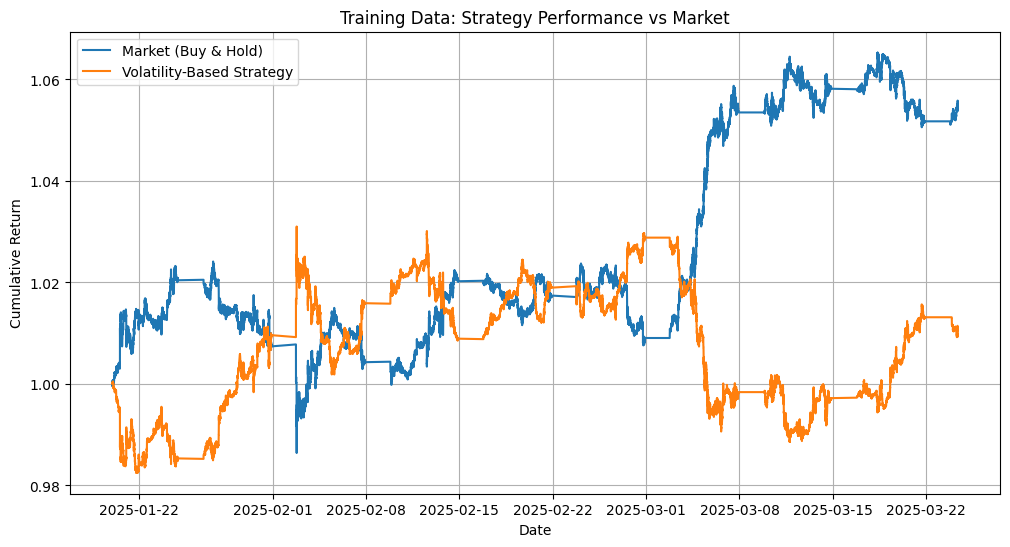

<ipython-input-17-a7e238607184>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['signal'] = 0
<ipython-input-17-a7e238607184>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['strategy_return'] = val_data['signal'].shift(1) * val_data['returns']
<ipython-input-17-a7e238607184>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

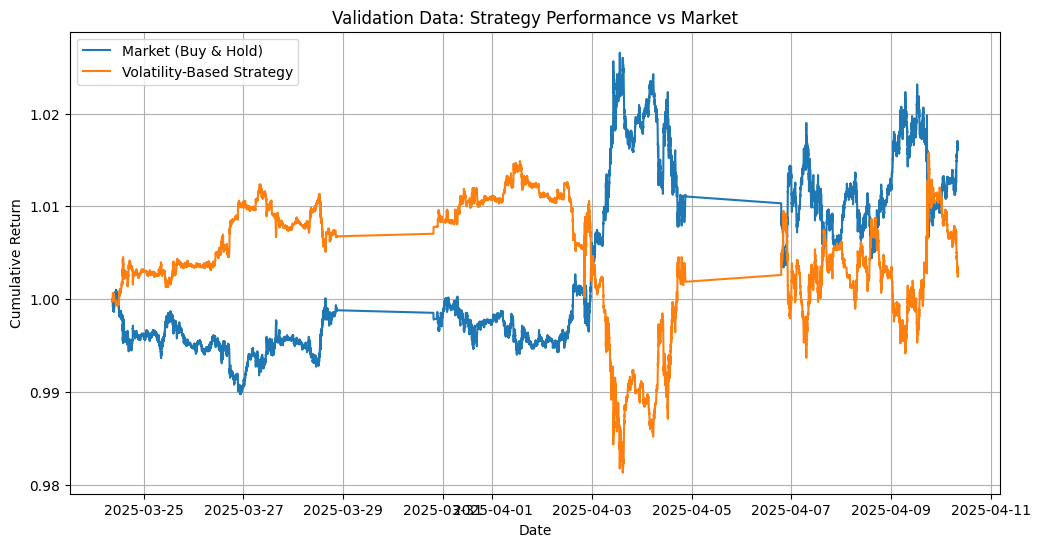

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter

# STEP 0: Load data and ensure 'Close' has a datetime index
sp = pd.read_csv("Eurousd.csv", parse_dates=['Date'], index_col='Date')  # Assuming 'Date' column exists
close = sp['Close'].dropna()

# STEP 1: Differencing to remove trend
diff_close = close.diff().dropna()

# STEP 2: Apply HP filter to extract trend and cyclical components
trend, cyclical = hpfilter(diff_close, lamb=1600)

# STEP 3: Deseasonalize using intraday seasonal mean removal
def deseasonalize_intraday_returns(df, return_col='returns'):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['time'] = df.index.time
    seasonal_pattern = df.groupby('time')[return_col].mean()
    df['seasonal_mean'] = df['time'].map(seasonal_pattern)
    df['deseasonalized'] = df[return_col] - df['seasonal_mean']
    return df['deseasonalized']

# Prepare input DataFrame for deseasonalization (fixing the index issue)
returns_df = pd.DataFrame({'returns': cyclical}, index=diff_close.index)
deseasonalized = deseasonalize_intraday_returns(returns_df, return_col='returns')

# Optional: Scaling the deseasonalized data
deseasonalized_scaled = (deseasonalized - deseasonalized.mean()) / deseasonalized.std()

# STEP 4: Calculate Realized Volatility (RV) using window and D (sampling interval)
D = 5  # Interval size (e.g., 5-minute returns)
window = 5  # Rolling window size for volatility calculation

# Calculate the squared returns (returns^2)
squared_returns = deseasonalized_scaled ** 2

# Calculate Realized Volatility (RV) using a rolling window and D
sp['squared_return'] = squared_returns
sp['realized_vol_D'] = sp['squared_return'].rolling(window=window).sum() / D
sp['realized_vol_D'] = np.sqrt(sp['realized_vol_D'])

# STEP 5: ADF Test function
def run_adf(series, label):
    result = adfuller(series.dropna())
    print(f"ADF Test - {label}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    print("-" * 50)

# Run ADF tests
run_adf(close, "Original Close")
run_adf(diff_close, "Differenced Close")
run_adf(cyclical, "HP Filter - Cyclical Component")
run_adf(deseasonalized, "Deseasonalized (Intraday Mean Removed)")
run_adf(deseasonalized_scaled, "Scaled Deseasonalized")
run_adf(sp['realized_vol_D'], "Realized Volatility (RV)")

# STEP 6: Split Data into 70% Training + 20% Validation, and leave 30% for Testing
train_size = int(0.7 * len(sp))
val_size = int(0.2 * len(sp))

train_data = sp.iloc[:train_size]
val_data = sp.iloc[train_size:train_size + val_size]
final_test_data = sp.iloc[train_size + val_size:]

# Calculate returns for all datasets
train_data['returns'] = train_data['Close'].pct_change()
val_data['returns'] = val_data['Close'].pct_change()

# STEP 7: Apply Volatility-Based Strategy
# Training Data
low_vol_threshold_train = train_data['realized_vol_D'].quantile(0.3)
high_vol_threshold_train = train_data['realized_vol_D'].quantile(0.7)

train_data['signal'] = 0
train_data.loc[train_data['realized_vol_D'] < low_vol_threshold_train, 'signal'] = 1   # Long
train_data.loc[train_data['realized_vol_D'] > high_vol_threshold_train, 'signal'] = -1  # Short

# Backtest the strategy for the training data
train_data['strategy_return'] = train_data['signal'].shift(1) * train_data['returns']
train_data['cumulative_strategy_return'] = (1 + train_data['strategy_return'].fillna(0)).cumprod()
train_data['cumulative_market_return'] = (1 + train_data['returns'].fillna(0)).cumprod()

# Plot cumulative returns for the training data
plt.figure(figsize=(12, 6))
plt.plot(train_data['cumulative_market_return'], label='Market (Buy & Hold)')
plt.plot(train_data['cumulative_strategy_return'], label='Volatility-Based Strategy')
plt.title("Training Data: Strategy Performance vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# Validation Data
low_vol_threshold_val = val_data['realized_vol_D'].quantile(0.3)
high_vol_threshold_val = val_data['realized_vol_D'].quantile(0.7)

val_data['signal'] = 0
val_data.loc[val_data['realized_vol_D'] < low_vol_threshold_val, 'signal'] = 1   # Long
val_data.loc[val_data['realized_vol_D'] > high_vol_threshold_val, 'signal'] = -1  # Short

# Backtest the strategy for the validation data
val_data['strategy_return'] = val_data['signal'].shift(1) * val_data['returns']
val_data['cumulative_strategy_return'] = (1 + val_data['strategy_return'].fillna(0)).cumprod()
val_data['cumulative_market_return'] = (1 + val_data['returns'].fillna(0)).cumprod()

# Plot cumulative returns for the validation data
plt.figure(figsize=(12, 6))
plt.plot(val_data['cumulative_market_return'], label='Market (Buy & Hold)')
plt.plot(val_data['cumulative_strategy_return'], label='Volatility-Based Strategy')
plt.title("Validation Data: Strategy Performance vs Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Simple Sharpe Ratio calculation (without risk-free rate)
def calculate_simple_sharpe_ratio(returns):
    # Mean of returns / Standard deviation of returns
    return returns.mean() / returns.std()

# Calculate Sharpe Ratio for the Training Data Strategy (Strategy returns)
sharpe_ratio_train = calculate_simple_sharpe_ratio(train_data['strategy_return'].dropna())
print(f"Sharpe Ratio for Training Data Strategy: {sharpe_ratio_train:.4f}")

# Calculate Sharpe Ratio for the Market Return (Buy & Hold) for Training Data
sharpe_ratio_market_train = calculate_simple_sharpe_ratio(train_data['returns'].dropna())
print(f"Sharpe Ratio for Training Data Market: {sharpe_ratio_market_train:.4f}")

# Calculate Sharpe Ratio for the Validation Data Strategy (Strategy returns)
sharpe_ratio_val = calculate_simple_sharpe_ratio(val_data['strategy_return'].dropna())
print(f"Sharpe Ratio for Validation Data Strategy: {sharpe_ratio_val:.4f}")

# Calculate Sharpe Ratio for the Market Return (Buy & Hold) for Validation Data
sharpe_ratio_market_val = calculate_simple_sharpe_ratio(val_data['returns'].dropna())
print(f"Sharpe Ratio for Validation Data Market: {sharpe_ratio_market_val:.4f}")


Sharpe Ratio for Training Data Strategy: 0.0011
Sharpe Ratio for Training Data Market: 0.0050
Sharpe Ratio for Validation Data Strategy: 0.0009
Sharpe Ratio for Validation Data Market: 0.0040


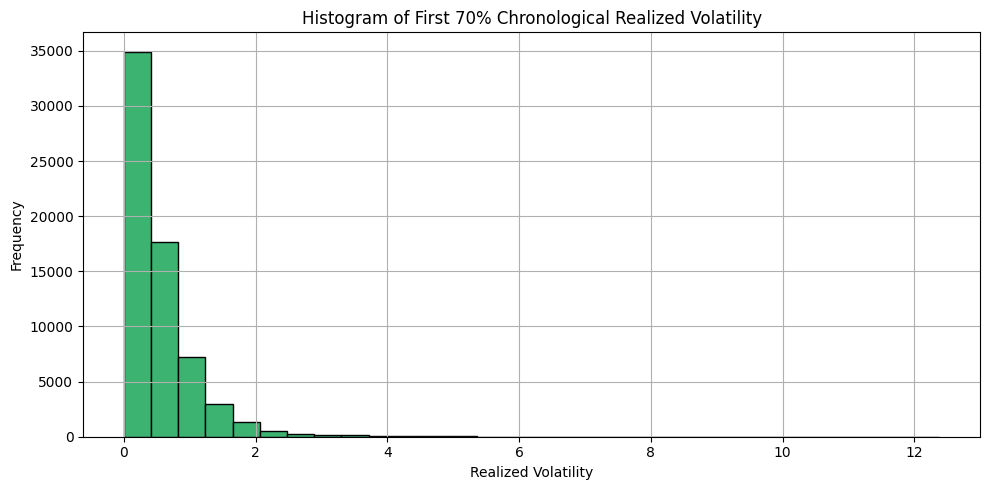

In [ ]:
# STEP 7: Take first 70% of the realized volatility data chronologically
realized_vol = sp['realized_vol_D'].dropna()
cutoff_index = int(len(realized_vol) * 0.7)
realized_vol_first_70 = realized_vol.iloc[:cutoff_index]

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(realized_vol_first_70, bins=30, color='mediumseagreen', edgecolor='black')
plt.title("Histogram of First 70% Chronological Realized Volatility")
plt.xlabel("Realized Volatility")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


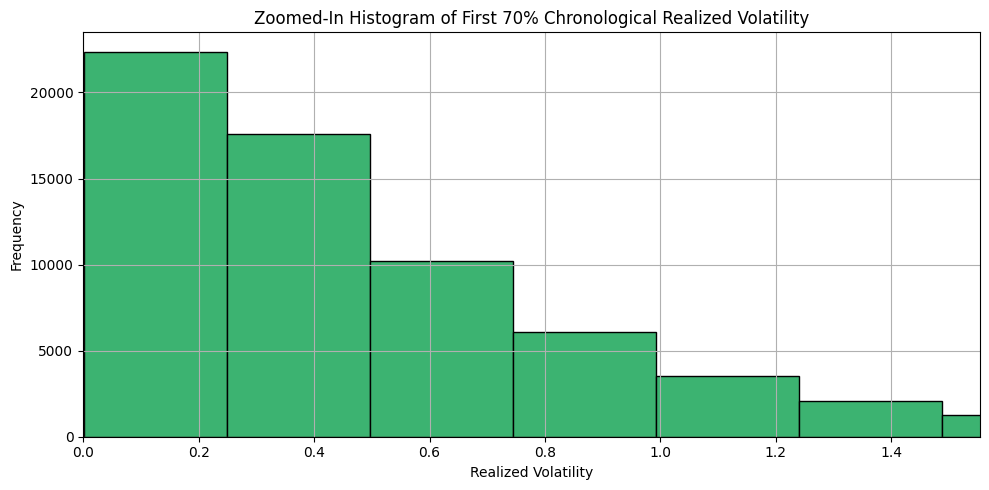

In [ ]:
# STEP 7 (Updated): Zoomed-in histogram of first 70% of realized volatility
realized_vol = sp['realized_vol_D'].dropna()
cutoff_index = int(len(realized_vol) * 0.7)
realized_vol_first_70 = realized_vol.iloc[:cutoff_index]

# Plot histogram with more bins and limited x-axis
plt.figure(figsize=(10, 5))
plt.hist(realized_vol_first_70, bins=50, color='mediumseagreen', edgecolor='black')
plt.title("Zoomed-In Histogram of First 70% Chronological Realized Volatility")
plt.xlabel("Realized Volatility")
plt.ylabel("Frequency")
plt.xlim(0, realized_vol_first_70.quantile(0.95))  # Zoom in to 95th percentile
plt.grid(True)
plt.tight_layout()
plt.show()



Text(2025-02-02 19:22:00, 12.388361017818692, 'Max: 12.3784')

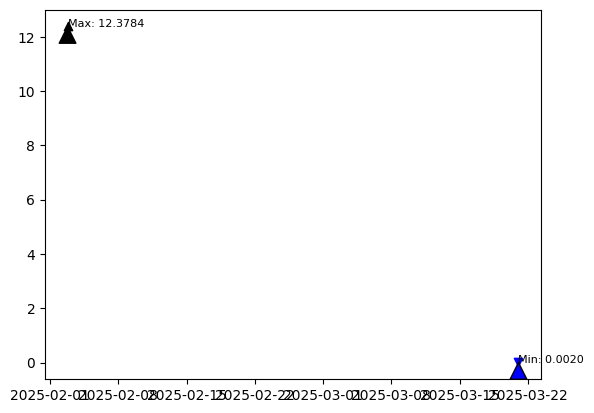

In [ ]:
# Find index of min and max RV
min_idx = sp['realized_vol_D'].idxmin()
max_idx = sp['realized_vol_D'].idxmax()
min_val = sp['realized_vol_D'].min()
max_val = sp['realized_vol_D'].max()

# Plot min and max points
plt.scatter(min_idx, min_val, color='blue', marker='v', label='Min RV')
plt.scatter(max_idx, max_val, color='black', marker='^', label='Max RV')

# Annotate the points
plt.annotate(f'Min: {min_val:.4f}', xy=(min_idx, min_val), xytext=(min_idx, min_val + 0.01),
             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=8)
plt.annotate(f'Max: {max_val:.4f}', xy=(max_idx, max_val), xytext=(max_idx, max_val + 0.01),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=8)


# REGRESSION RESULTS

In [ ]:
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 57.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from arch.__future__ import reindexing  # future-proof indexing

# Load your data
# Replace this line with the actual loading method for your data
# Example: sp = pd.read_csv("your_data.csv", parse_dates=True, index_col='Date')
realized_vol = sp['realized_vol_D'].dropna()
y = realized_vol.copy()
n_train = int(len(y) * 0.999)

In [ ]:
# EWMA Volatility
def ewma_volatility(series, lambda_=0.94):
    ewma = []
    prev = series.var()
    for r in series:
        var = lambda_ * prev + (1 - lambda_) * r**2
        ewma.append(np.sqrt(var))
        prev = var
    return pd.Series(ewma, index=series.index)

# Containers for forecasts
rv_ewma = []
rv_gjr_garch = []
rv_aparch = []
rv_figarch = []
rv_arrv = []


In [ ]:
for i in tqdm(range(n_train, len(y)), desc="Rolling Forecast"):
    train = y[:i]

    # EWMA
    try:
        ewma = ewma_volatility(train)
        rv_ewma.append(ewma.iloc[-1])
    except:
        rv_ewma.append(np.nan)

    # GJR-GARCH(1,1,1)
    try:
        gjr = arch_model(train, vol='GARCH', p=1, o=1, q=1, dist='normal')
        res_gjr = gjr.fit(disp='off')
        forecast = res_gjr.forecast(horizon=1).variance.values[-1, 0]
        rv_gjr_garch.append(np.sqrt(forecast))
    except:
        rv_gjr_garch.append(np.nan)

    # APARCH(1,1)
    try:
        aparch = arch_model(train, vol='APARCH', p=1, q=1, dist='normal')
        res_aparch = aparch.fit(disp='off')
        forecast = res_aparch.forecast(horizon=1).variance.values[-1, 0]
        rv_aparch.append(np.sqrt(forecast))
    except:
        rv_aparch.append(np.nan)

    # FIGARCH(1,d,1)
    try:
        figarch = arch_model(train, vol='FIGARCH', p=1, q=1, dist='normal')
        res_figarch = figarch.fit(disp='off')
        forecast = res_figarch.forecast(horizon=1).variance.values[-1, 0]
        rv_figarch.append(np.sqrt(forecast))
    except:
        rv_figarch.append(np.nan)

    # AR-RV
    try:
        ar_model = AutoReg(train, lags=1).fit()
        forecast = ar_model.predict(start=len(train), end=len(train))
        rv_arrv.append(float(forecast))
    except:
        rv_arrv.append(np.nan)




Rolling Forecast:   0%|          | 0/94 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment

In [ ]:
# Create DataFrame
forecast_index = y.index[n_train:]
df_results = pd.DataFrame({
    'actual': y[n_train:].values,
    'EWMA': rv_ewma,
    'GJR-GARCH': rv_gjr_garch,
    'APARCH': rv_aparch,
    'FIGARCH': rv_figarch,
    'AR-RV': rv_arrv
}, index=forecast_index)

# R² OS Function
def r2_os(y_true, y_pred, benchmark):
    num = np.sum((y_true - y_pred)**2)
    denom = np.sum((y_true - benchmark)**2)
    return 1 - num / denom

# Benchmark = Historical mean of training set
benchmark = np.mean(y[:n_train])

# R² OS Outputs
print("R² OS (EWMA):", r2_os(df_results['actual'], df_results['EWMA'], benchmark))
print("R² OS (GJR-GARCH):", r2_os(df_results['actual'], df_results['GJR-GARCH'], benchmark))
print("R² OS (APARCH):", r2_os(df_results['actual'], df_results['APARCH'], benchmark))
print("R² OS (FIGARCH):", r2_os(df_results['actual'], df_results['FIGARCH'], benchmark))
print("R² OS (AR-RV):", r2_os(df_results['actual'], df_results['AR-RV'], benchmark))


R² OS (EWMA): 0.9785844086156407
R² OS (GJR-GARCH): -244.48818707333868
R² OS (APARCH): -226.67759633726132
R² OS (FIGARCH): 0.29076075554084735
R² OS (AR-RV): 0.9978409724236196


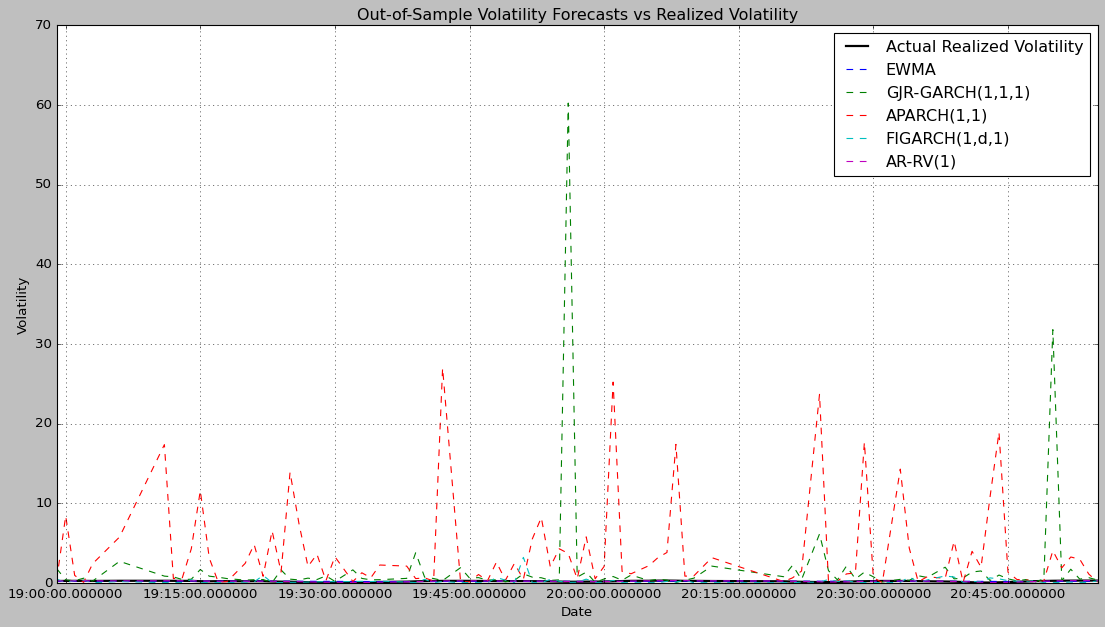

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('classic')  # or try 'ggplot', 'bmh', 'fivethirtyeight'

plt.figure(figsize=(14, 8))

# Plot actual vs forecasts
plt.plot(df_results.index, df_results['actual'], label='Actual Realized Volatility', linewidth=2, color='black')
plt.plot(df_results.index, df_results['EWMA'], label='EWMA', linestyle='--')
plt.plot(df_results.index, df_results['GJR-GARCH'], label='GJR-GARCH(1,1,1)', linestyle='--')
plt.plot(df_results.index, df_results['APARCH'], label='APARCH(1,1)', linestyle='--')
plt.plot(df_results.index, df_results['FIGARCH'], label='FIGARCH(1,d,1)', linestyle='--')
plt.plot(df_results.index, df_results['AR-RV'], label='AR-RV(1)', linestyle='--')

# Final plot settings
plt.title('Out-of-Sample Volatility Forecasts vs Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm
import pandas as pd

def run_regression(y, X, label):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"\n--- Regression for {label} ---")
    print(model.summary())
    return model

# Convert forecast lists to pandas Series with proper indexing
index = y[n_train:].index  # ensure alignment with actual values

df_results = pd.DataFrame({
    'actual': y[n_train:].values,
    'EWMA': pd.Series(rv_ewma, index=index),
    'GJR-GARCH': pd.Series(rv_gjr_garch, index=index),
    'APARCH': pd.Series(rv_aparch, index=index),
    'FIGARCH': pd.Series(rv_figarch, index=index),
    'AR-RV': pd.Series(rv_arrv, index=index)
}, index=index)

# Rename columns for regression
df_reg = df_results.rename(columns={
    'actual': 'RV_Actual',
    'EWMA': 'RV_EWMA',
    'GJR-GARCH': 'RV_GARCH',
    'APARCH': 'RV_APARCH',
    'FIGARCH': 'RV_FIGARCH',
    'AR-RV': 'RV_ARRV'
})

# Drop any rows with NaNs
df_reg_clean = df_reg.dropna()

# Run individual regressions
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_EWMA'], 'EWMA')
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_GARCH'], 'GARCH')
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_APARCH'], 'APARCH')
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_FIGARCH'], 'FIGARCH')
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_ARRV'], 'ARRV')

# Run joint regression
run_regression(
    df_reg_clean['RV_Actual'],
    df_reg_clean[['RV_EWMA', 'RV_GARCH', 'RV_APARCH', 'RV_FIGARCH', 'RV_ARRV']],
    'All Models'
)



--- Regression for EWMA ---
                            OLS Regression Results                            
Dep. Variable:              RV_Actual   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.235
Date:                Sun, 11 May 2025   Prob (F-statistic):             0.0754
Time:                        20:41:30   Log-Likelihood:                 122.37
No. Observations:                  94   AIC:                            -240.7
Df Residuals:                      92   BIC:                            -235.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0338  


| Model          | R-squared | Coefficient               | p-value         | Key Interpretation                                             |
| -------------- | --------- | ------------------------- | --------------- | -------------------------------------------------------------- |
| **EWMA**       | 0.034     | 0.816                     | 0.075           | Marginally significant; limited explanatory power              |
| **GARCH**      | 0.002     | -0.0004                   | 0.710           | Not significant; fails to predict realized volatility          |
| **APARCH**     | 0.001     | -0.0003                   | 0.775           | Not significant; no predictive value                           |
| **FIGARCH**    | 0.003     | -0.0098                   | 0.604           | Not significant; very low predictive value                     |
| **ARRV**       | 0.904     | 0.964                     | <0.001          | Highly significant; excellent predictor of realized volatility |
| **All Models** | 0.946     | ARRV: 1.051, EWMA: -0.984 | <0.001 for both | ARRV dominates; EWMA turns negative due to multicollinearity   |
